# Binary semantic segmentation

> Image segmentation, or semantic segmentation, is the task of classifying each pixel within an image with a corresponding class. 
For the binary semantic segmentation task, we will use the Heart MRI dataset from the Medical Segmentation Decathlon challenge (http://medicaldecathlon.com/) provided by King’s College London. The target is to segment the left atrium. The challenge with this dataset is that it is small and has considerable variability. 

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/fastMONAI/blob/master/nbs/10c_tutorial_binary_segmentation.ipynb)

In [ ]:
#| hide
#Install `fastMONAI` if notebook is running on Google Colab
try:
    import google.colab
    %pip install fastMONAI
    from fastMONAI.utils import print_colab_gpu_info
    print_colab_gpu_info()
except:
    print('Running locally')

Running locally


In [ ]:
from fastMONAI.vision_all import *

from monai.apps import DecathlonDataset
from sklearn.model_selection import train_test_split

### Download external data

We use the MONAI function `DecathlonDataset` to download the data and generate items for training. 

In [ ]:
path = Path('../data')
path.mkdir(exist_ok=True)

In [ ]:
task = "Task02_Heart"
training_data = DecathlonDataset(root_dir=path, task=task, section="training", 
    download=True, cache_num=0, num_workers=3)

2025-08-27 13:20:24,881 - INFO - Verified 'Task02_Heart.tar', md5: 06ee59366e1e5124267b774dbd654057.
2025-08-27 13:20:24,882 - INFO - File exists: ../data/Task02_Heart.tar, skipped downloading.
2025-08-27 13:20:24,883 - INFO - Non-empty folder exists in ../data/Task02_Heart, skipped extracting.


In [ ]:
df = pd.DataFrame(training_data.data)
df.shape

(16, 2)

Split the labled data into training and test

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df.shape, test_df.shape

((14, 2), (2, 2))

### Look at training data

Each class label will be counted for the masks (including the background) if you pass in the mask path and define the `dtype` to be `MedMask` in `MedDataset`

In [ ]:
med_dataset = MedDataset(img_list=train_df.label.tolist(), dtype=MedMask, max_workers=12)

In [ ]:
med_dataset.df.head()

,path,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,voxel_count_0,voxel_count_1
0,../data/Task02_Heart/labelsTr/la_023.nii.gz,320,320,110,1.25,1.25,1.37,RAS+,11220796,43204
1,../data/Task02_Heart/labelsTr/la_004.nii.gz,320,320,110,1.25,1.25,1.37,RAS+,11205525,58475
2,../data/Task02_Heart/labelsTr/la_007.nii.gz,320,320,130,1.25,1.25,1.37,RAS+,13256556,55444
3,../data/Task02_Heart/labelsTr/la_022.nii.gz,320,320,110,1.25,1.25,1.37,RAS+,11230449,33551
4,../data/Task02_Heart/labelsTr/la_011.nii.gz,320,320,120,1.25,1.25,1.37,RAS+,12229545,58455


In [ ]:
data_info_df = med_dataset.summary()

In [ ]:
data_info_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
3,320,320,110,1.25,1.25,1.37,RAS+,../data/Task02_Heart/labelsTr/la_004.nii.gz,4
4,320,320,120,1.25,1.25,1.37,RAS+,../data/Task02_Heart/labelsTr/la_005.nii.gz,4
1,320,320,100,1.25,1.25,1.37,RAS+,../data/Task02_Heart/labelsTr/la_009.nii.gz,2
2,320,320,109,1.25,1.25,1.37,RAS+,../data/Task02_Heart/labelsTr/la_029.nii.gz,1
0,320,320,90,1.25,1.25,1.37,RAS+,../data/Task02_Heart/labelsTr/la_016.nii.gz,1


In [ ]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([1.25, 1.25, 1.37], False)

In [ ]:
bs=4

In [ ]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size #TODO fix this that it returns np.float64 

[np.float64(320.0), np.float64(320.0), np.float64(130.0)]

In [ ]:
size = [160,160,128]

In [ ]:
item_tfms = [ZNormalization(), PadOrCrop(size), RandomAffine(scales=0, degrees=5)]  # RandomMotion()

In [ ]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=RandomSplitter(valid_pct=0.1, seed=42), # By passing valid_pct=0.1, we tell it to get a random 10% of the training set for validation.
                      get_x=ColReader('image'),
                      get_y=ColReader('label'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [ ]:
dls = dblock.dataloaders(train_df, bs=bs)

In [ ]:
# training and validation
len(dls.train_ds.items), len(dls.valid_ds.items)

(13, 1)

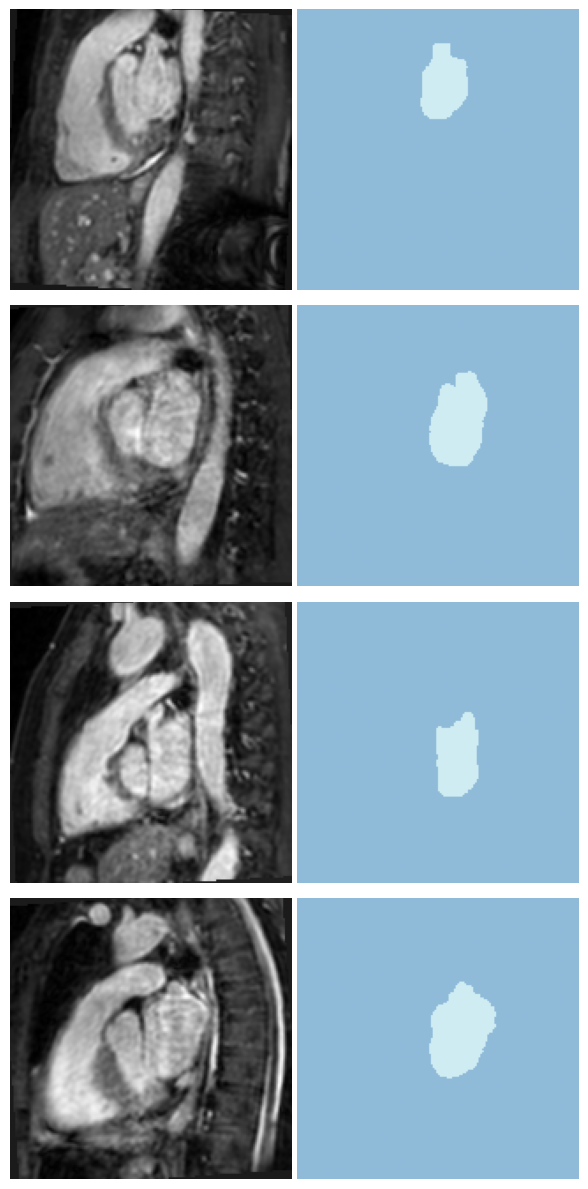

In [ ]:
dls.show_batch(anatomical_plane=2) 

### Create and train a 3D model

The current state-of-the-art CNN models for medical image segmentation tasks are based on encoder-decoder architectures like the U-Net. 
In the following line, we import an enhanced version of 3D UNet from MONAI. In addition, we import the Dice coefficient (Dice) loss, a commonly used loss function in medical image segmentation tasks: 
\begin{equation*}
\begin{aligned}
loss = 1- \frac{y \cap \hat{y}}{\left | y \right |+\left | \hat{y} \right |}
\end{aligned}
\end{equation*}

In [ ]:
from monai.networks.nets import UNet
from monai.losses import DiceLoss

In [ ]:
monai_model = UNet(spatial_dims=3, in_channels=1, out_channels=1, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), num_res_units=2)
pytorch_model = monai_model.model

In [ ]:
loss_func = CustomLoss(loss_func=DiceLoss(sigmoid=True))

We use a built-in ranger optimizer from fastai, that combines (RAdam + Lookahead) into a single optimizer. 
<i>Ranger21 tested with fastai available:</i> https://github.com/lessw2020/Ranger21

In [ ]:
learn = Learner(dls, pytorch_model, loss_func=loss_func, opt_func=ranger, metrics=binary_dice_score)

SuggestedLRs(valley=0.013182567432522774)

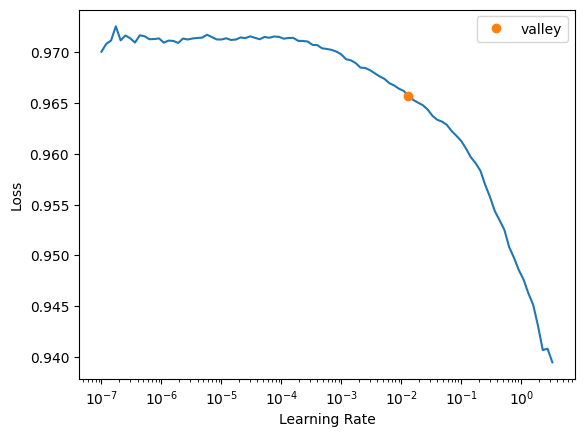

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-2

As shown in https://walkwithfastai.com/Segmentation, with the ranger optimizer, we want to use a different fit function, called `fit_flat_cos`

In [ ]:
import mlflow

# Set experiment name
mlflow.set_experiment(task)

mlflow_callback = ModelTrackingCallback(
    model_name=f"{task}_{monai_model._get_name()}",
    loss_function=loss_func.loss_func._get_name(),
    item_tfms=item_tfms,
    size=size,
    resample=resample,
    reorder=reorder,
)

with mlflow.start_run(run_name="initial_training"):
    learn.fit_flat_cos(200, lr, cbs=[mlflow_callback])

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

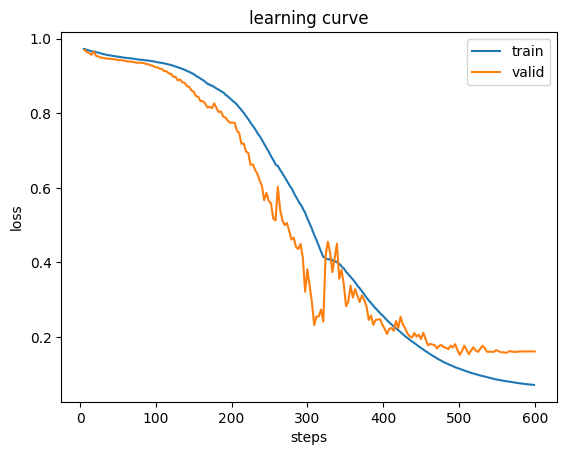

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('heart-weights')

Path('models/heart-weights.pth')

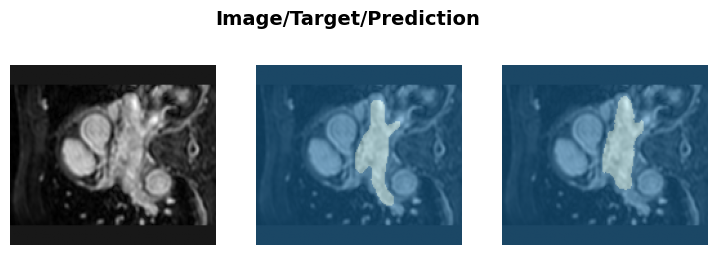

In [ ]:
learn.show_results(anatomical_plane=1)

### Test data (with labels to evaulate the model)
Evaluate the performance of the selected model on unseen data. 
It’s important to not touch this data until you have fine tuned your model to get an unbiased evaluation!

In [ ]:
learn.load('heart-weights');

In [ ]:
test_dl = learn.dls.test_dl(test_df,with_labels=True)

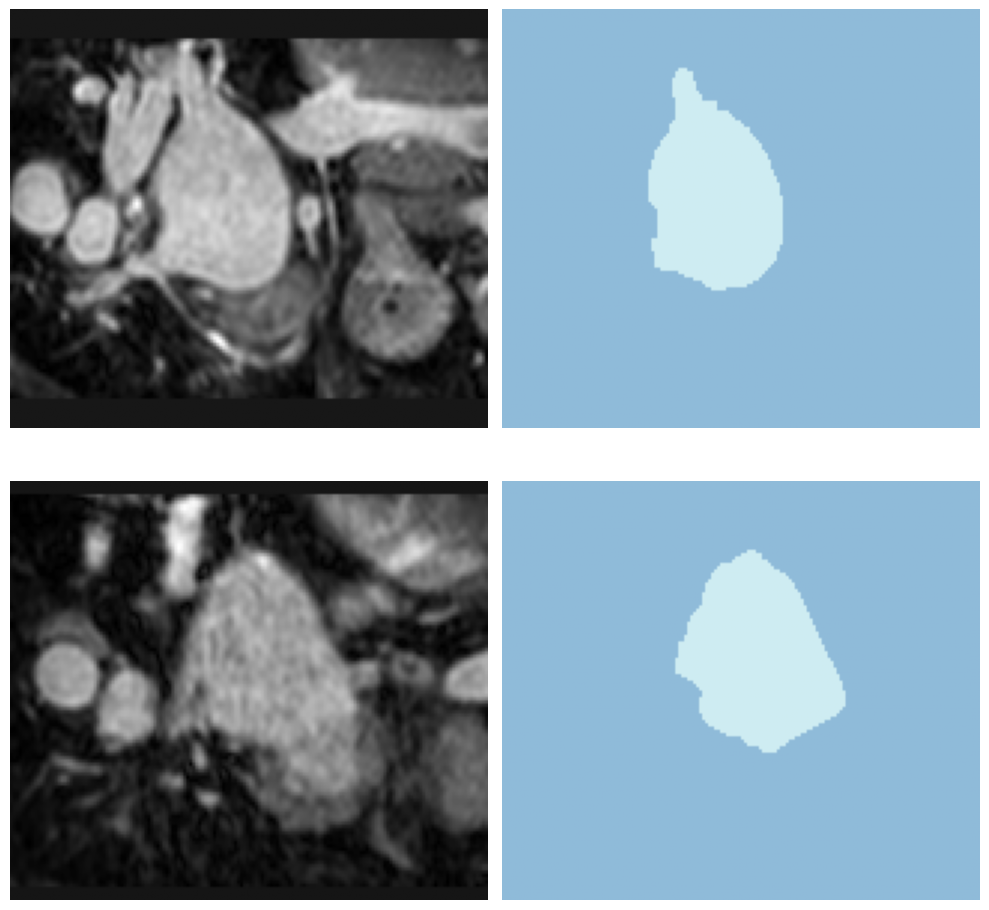

In [ ]:
test_dl.show_batch(anatomical_plane=0, figsize=(10,10))

In [ ]:
pred_acts, labels = learn.get_preds(dl=test_dl)
pred_acts.shape, labels.shape

(torch.Size([2, 1, 160, 160, 128]), torch.Size([2, 1, 160, 160, 128]))

In [ ]:
binary_dice_score(pred_acts, labels)

tensor(0.9120)

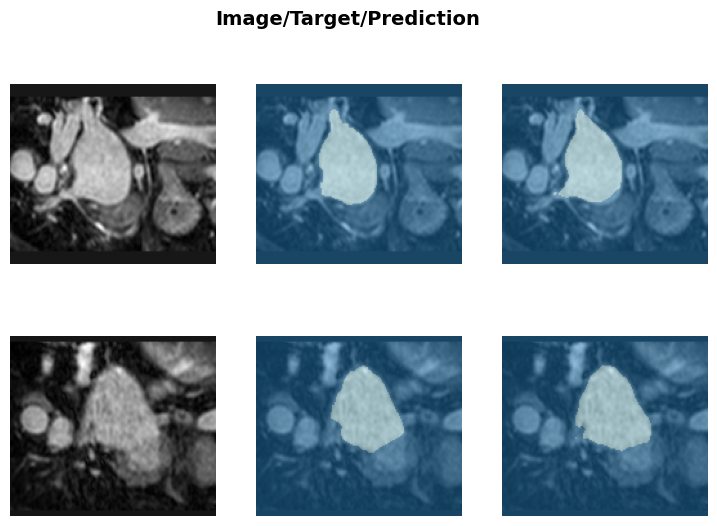

In [ ]:
learn.show_results(anatomical_plane=0, dl=test_dl)